In [1]:
import os
os.getcwd()

'/content'

In [0]:
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [3]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks'

In [0]:
%tensorflow_version 2.x

# Imports

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [6]:
from datasets import MNISTDataset
print(tf.__version__)

2.2.0-rc3


# Loading the data

We can see that there are 60,000 training examples and 10,000 test examples. Each image is 28x28 pixels and they are represented as 28x28 arrays filled with values ranging between 0 and 255. 0 meaning white(background) and 255 meaning black(foreground).

In [7]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data() #tuple of numpy arrays

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


We can plot a training image and see how it looks. The corresponding label is also printed and we can see that it matches with the image.


label = 4


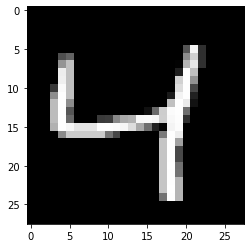

In [8]:
print("label = "+str(train_labels[2]))
plt.imshow(train_images[2], cmap="Greys_r")

# Setup

Next, we flatten the 28x28 array to a vector of 784 numbers and intialize the model parameters. 

Initializing the weight variables to zeros would not work well. If all the weights are same, then they all will have the same error and the model will not learn anything. The best option is to keep the weights very close to 0, and by making them different by randomly initilaiizing them between two small non-zero numbers, such as -0.1 and 0.1.

In [0]:
data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)

train_steps = 1000
learning_rate = 0.5

# adding the weights connecting the input to the hidden layer
W1 = tf.Variable(tf.random.uniform([784, 50],minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32))
b1 = tf.Variable(np.ones(50, dtype=np.float32))

# adding the weights connecting the hidden layer to the output layer
W2 = tf.Variable(tf.random.uniform([50, 10],minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32))
b2 = tf.Variable(np.zeros(10, dtype=np.float32))

# Training loop

We train the model using gradient descent to update the weights and the bias variables to reduce the loss.

We have used ReLu activation function for our model. 

In [10]:
#start of training
for step in range(train_steps):
    img_batch, lbl_batch = data.next_batch()   
    with tf.GradientTape(persistent=True) as tape:  
          hidden_out = tf.matmul(img_batch, W1)+ b1
          hidden_out = tf.nn.relu(hidden_out)
          logits = tf.matmul(hidden_out, W2) + b2        
          xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=lbl_batch))       
          
    grads2 = tape.gradient(xent, [W2, b2])
    grads1 = tape.gradient(xent, [W1, b1])
    
    W2.assign_sub(learning_rate * grads2[0])
    b2.assign_sub(learning_rate * grads2[1])    
    W1.assign_sub(learning_rate * grads1[0])
    b1.assign_sub(learning_rate * grads1[1])
    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                             tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))

Loss: 2.4084157943725586 Accuracy: 0.1015625
Loss: 0.4853323698043823 Accuracy: 0.8515625
Loss: 0.3186534643173218 Accuracy: 0.90625
Loss: 0.13704808056354523 Accuracy: 0.9609375
Loss: 0.1821276694536209 Accuracy: 0.9453125
Starting new epoch...
Loss: 0.22345072031021118 Accuracy: 0.921875
Loss: 0.15489408373832703 Accuracy: 0.9453125
Loss: 0.11914148181676865 Accuracy: 0.9609375
Loss: 0.32475364208221436 Accuracy: 0.9140625
Loss: 0.06491954624652863 Accuracy: 0.9921875
Starting new epoch...


# Testing

In [11]:
#Accuracy check on the Test set
h_layer=tf.matmul(data.test_data, W1) + b1
hidden_out = tf.nn.relu(h_layer)
test_preds = tf.argmax(tf.matmul(hidden_out,W2) + b2, axis=1,
                       output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
                             tf.float32))
print(acc)

tf.Tensor(0.9608, shape=(), dtype=float32)


# Few observations

1. Increasing the training steps gives better accuracy results, but there is no significant difference.

2. Increasing the learning rate also gave us better accuracy results. When the learning rate is 0.1, accuracy was 92%. By increasing it to 0.5, we got an accuracy of 96%, which is really good given that we have used only one hidden layer. But increasing it further does not improve the accuracy.

3. Changing the weight initializations makes a lot of difference in the results. The accuracy significantly decreases if the weights are initialized to 0, and also if the initializations are farther from 0. For example, setting the weights between [-0.2 , 0.2] gave an accuracy of 85%. The best initializations seems to be between -0.1 and 0.1.

4. Modifying the hidden layer sizes or adding more hidden layers makes no significant differences to the accuracy. The accuracy at size 50 is almost same as the accuracy at 500. This proves that MNIST dataset can give good results even with a simple model. 

# Evaluation

We can see from the confusion matrix that 0 is most commonly being incorrectly predicted as 6. 1 as 8, 2 also as 8, 3 as 5, and so on.

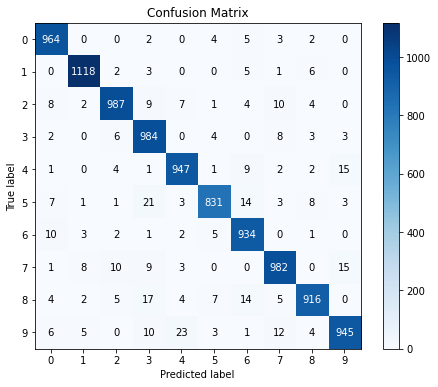

In [12]:
! pip install -q scikit-plot
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    test_labels, 
    test_preds,
    figsize=(8,6))

# Correct and incorrect predictions

We can see from the following images the correctly classified images and the incorrectly classified ones. For this run, 9608  instances are classified correctly and 392 are instances classified incorrectly. The correctly classified images are clear and there seems to be no ambiguity in classifying them. The incorrectly classified images are ambiguous and we can see why they were misclassified. For example, 5 and 6 can be confused together since they have a common loop. 


9608  instances classified correctly
392  instances classified incorrectly


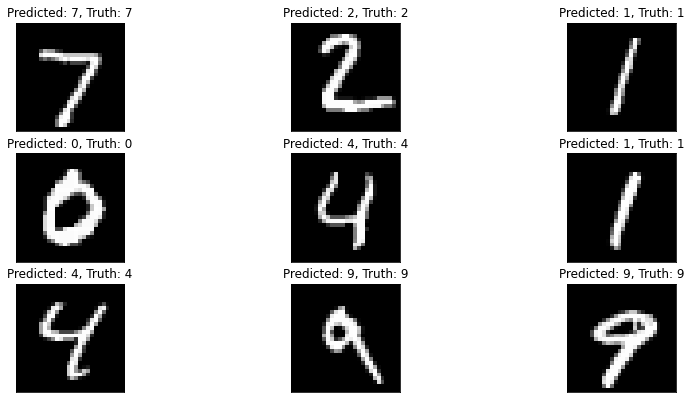

In [13]:
predicted_classes = test_preds

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == test_labels)[0]
incorrect_indices = np.nonzero(predicted_classes != test_labels)[0]
print()
print(len(correct_indices)," instances classified correctly")
print(len(incorrect_indices)," instances classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (14,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(test_images[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        test_labels[correct]))
    plt.xticks([])
    plt.yticks([])

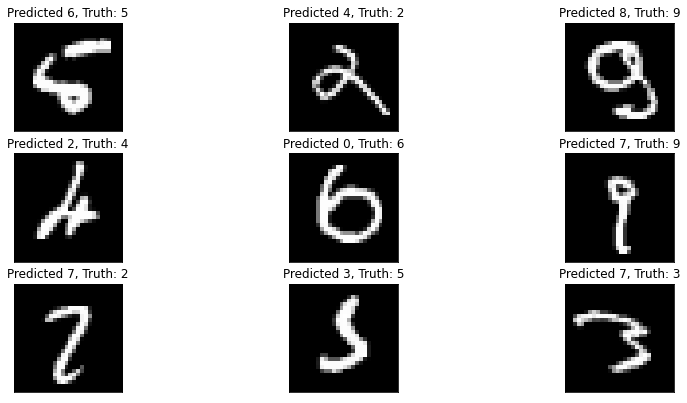

In [14]:
# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(test_images[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       test_labels[incorrect]))
    plt.xticks([])
    plt.yticks([])

# Fashion MNIST implementation

We perform the same steps as above for Fashion MNIST dataset.

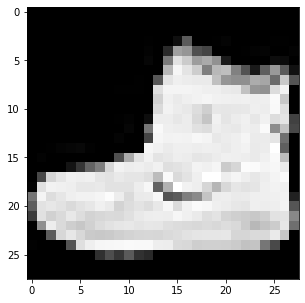

In [23]:
mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
plt.figure(figsize = (28,5))
plt.imshow(train_images[0], cmap="Greys_r")

We add two hidden layers with size 450 and 250 neurons. With Fashion MNIST we see that even with two hidden layers, the accuracy is not much, only ~ 84%. Increasing the learning rate also does not improve the accuracy. Infact, it decreases it. 

In [34]:
data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)

train_steps = 1000
learning_rate = 0.1

# adding the weights connecting the input to the hidden layer 1
W1 = tf.Variable(tf.random.uniform([784, 450],minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32))
b1 = tf.Variable(np.ones(450, dtype=np.float32))

# adding the weights connecting the hidden layer1 to the hidden layer 2
W2 = tf.Variable(tf.random.uniform([450, 250],minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32))
b2 = tf.Variable(np.ones(250, dtype=np.float32))

# adding the weights connecting the hidden layer to the output layer
W3 = tf.Variable(tf.random.uniform([250, 10],minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32))
b3 = tf.Variable(np.zeros(10, dtype=np.float32))

#start of training
for step in range(train_steps):
    img_batch, lbl_batch = data.next_batch()   
    with tf.GradientTape(persistent=True) as tape:  
          hidden_out1 = tf.matmul(img_batch, W1)+ b1
          hidden_out1 = tf.nn.relu(hidden_out1)
          hidden_out2 = tf.matmul(hidden_out1, W2) + b2
          hidden_out2 = tf.nn.relu(hidden_out2)
          logits = tf.matmul(hidden_out2, W3) + b3        
          xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=lbl_batch))       

    grads3 = tape.gradient(xent, [W3, b3])    
    grads2 = tape.gradient(xent, [W2, b2])
    grads1 = tape.gradient(xent, [W1, b1])
    

    W3.assign_sub(learning_rate * grads3[0])
    b3.assign_sub(learning_rate * grads3[1])
    W2.assign_sub(learning_rate * grads2[0])
    b2.assign_sub(learning_rate * grads2[1])    
    W1.assign_sub(learning_rate * grads1[0])
    b1.assign_sub(learning_rate * grads1[1])
    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                             tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))

Loss: 3.0457053184509277 Accuracy: 0.078125
Loss: 0.6769232749938965 Accuracy: 0.765625
Loss: 0.6984031796455383 Accuracy: 0.734375
Loss: 0.5698890686035156 Accuracy: 0.796875
Loss: 0.5053102970123291 Accuracy: 0.8203125
Starting new epoch...
Loss: 0.45618176460266113 Accuracy: 0.875
Loss: 0.3490481376647949 Accuracy: 0.859375
Loss: 0.47507166862487793 Accuracy: 0.8046875
Loss: 0.3879550099372864 Accuracy: 0.8515625
Loss: 0.4567173719406128 Accuracy: 0.8359375
Starting new epoch...


In [35]:
#Accuracy check on the Test set
h_layer1=tf.matmul(data.test_data, W1) + b1
hidden_out1 = tf.nn.relu(h_layer1)
h_layer2=tf.matmul(hidden_out1, W2) + b2
hidden_out2 = tf.nn.relu(h_layer2)
test_preds = tf.argmax(tf.matmul(hidden_out2,W3) + b3, axis=1,
                       output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
                             tf.float32))
print(acc)

tf.Tensor(0.8445, shape=(), dtype=float32)


# Evaluation

We can see from the confusion matrix that 0 (T-shirt) is commonly incorrectly predicted as 6 (Shirt).

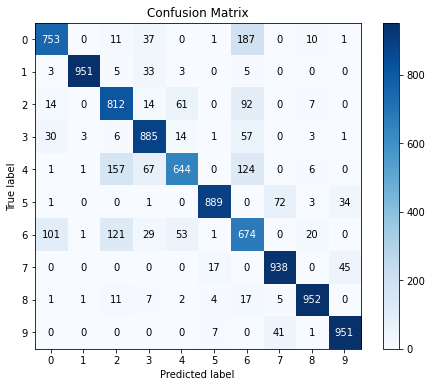

In [18]:
skplt.metrics.plot_confusion_matrix(
    test_labels, 
    test_preds,
    figsize=(8,6))


8449  instances classified correctly
1551  instances classified incorrectly


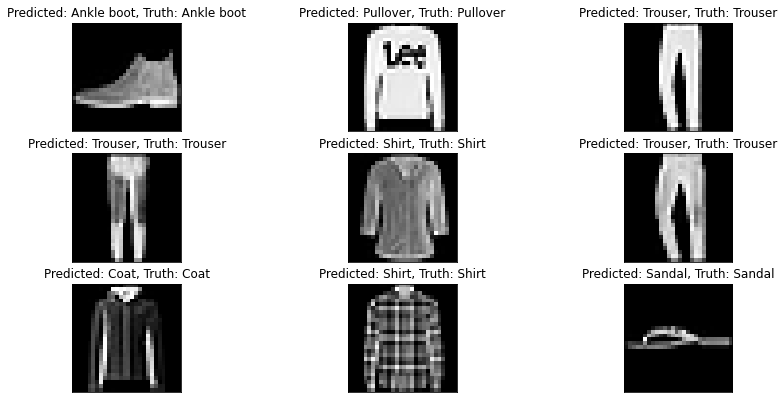

In [19]:
predicted_classes = test_preds
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9
# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == test_labels)[0]
incorrect_indices = np.nonzero(predicted_classes != test_labels)[0]
print()
print(len(correct_indices)," instances classified correctly")
print(len(incorrect_indices)," instances classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (14,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(test_images[correct].reshape(28,28), cmap='gray', interpolation='none')
    predict_index = predicted_classes[correct]
    true_index = test_labels[correct]
    plt.title(
      "Predicted: {}, Truth: {}".format(fashion_mnist_labels[predict_index],
                                        fashion_mnist_labels[true_index]))
    plt.xticks([])
    plt.yticks([])


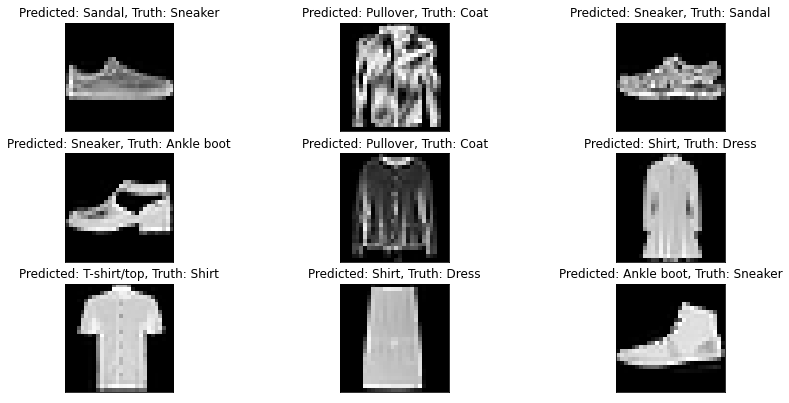

In [20]:
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9
# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(test_images[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    predict_index = predicted_classes[incorrect]
    true_index = test_labels[incorrect]
    plt.title(
      "Predicted: {}, Truth: {}".format(fashion_mnist_labels[predict_index],
                                        fashion_mnist_labels[true_index]))
    plt.xticks([])
    plt.yticks([])

# Final conclusions

We added a hidden layer to our model for MNIST dataset which gave us a good accuracy of 96%. We found that MNIST is not a very complex dataset and gives good results even for a simple model. 

Fashion MNIST dataset is much more complex and challenging. 

We also note that some parts of the code such as creating layers, weight and bias updation can be replaced with higher level interfaces using APIs from Keras. 